In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import scipy.io as spio

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

from evaluation import accuracy
from evaluation import areaundercurve
from evaluation import average_precision_score_computation

Using matplotlib backend: agg


In [2]:
class NaiveConv(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(NaiveConv, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(in_channel, out_channel),
            torch.nn.Tanh()
        )
        
    def forward(self, x, adj):
        h = self.layers(x)
        x = torch.mm(
            adj,
            h
        )
        return x

class Net(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Net, self).__init__()
        
        self.conv1 = NaiveConv(in_channel, 16)
        self.conv2 = NaiveConv(16, out_channel)
        
    def forward(self, data):
        x, adj = data.x, data.adj
        
        x = self.conv1(x, adj)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, adj)
        return F.log_softmax(x, dim=1)

In [3]:
from tqdm import tqdm

NUMEPOCHS = 10000
early_stop_win_size = 100
tolerance = 0.005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data
name = 'Cora'
dataset = Planetoid('../datasets/'+ name, name=name)

in_dim = dataset.num_node_features
out_dim = dataset.num_classes

data = dataset.data
# data.adj = to_dense_adj(data.edge_index)[0]
# data.adj = to_dense_adj(add_self_loops(data.edge_index)[0])[0]
data.adj = torch.zeros(data.x.size(0), data.x.size(0))
data = dataset.data.to(device)

# compile model
model = Net(
    in_dim,
    out_dim
).to(device)

optimizer = torch.optim.Adamax(model.parameters(), weight_decay=1e-4)

In [4]:
# record accuracy
train_acc = np.zeros(NUMEPOCHS)
val_acc = np.zeros(NUMEPOCHS)
test_acc = np.zeros(NUMEPOCHS)

# training start
model.train()

for epoch in range(NUMEPOCHS):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    # record the accuracy
    train_acc[epoch] = accuracy(model, data, 'train')
    val_acc[epoch] = accuracy(model, data, 'val')
    test_acc[epoch] = accuracy(model, data, 'test')
    
    # early stopping
    if epoch > 2 * early_stop_win_size:
        prev_start = epoch - 2 * early_stop_win_size
        prev_end = epoch - early_stop_win_size
        current_start = epoch - early_stop_win_size
        current_end = epoch
        
        val_acc_current = np.mean(val_acc[current_start: current_end])
        val_acc_previous = np.mean(val_acc[prev_start: prev_end])
        
        if val_acc_current < val_acc_previous - tolerance:
            train_acc = train_acc[:epoch]
            val_acc = val_acc[:epoch]
            test_acc = test_acc[:epoch]
            print('Moving Average Early stopping at %d-th epoch' % epoch)
            print(
                'Previous validation average accuracy for %d-th to %d-th epoch: %f' % \
                (prev_start, prev_end, val_acc_previous)
            )
            print(
                'Current validation average accuracy for %d-th to %d-th epoch: %f' % \
                (current_start, current_end, val_acc_current)
            )
            break
            
    # print out loss
    if epoch % 1000 == 0:
        print(
            epoch, 
            'training acc =', train_acc[epoch], 
            ', loss =', loss.item()
        )

0 training acc = 0.14285714285714285 , loss = 1.9459106922149658
1000 training acc = 0.14285714285714285 , loss = 1.9459106922149658
2000 training acc = 0.14285714285714285 , loss = 1.9459106922149658
3000 training acc = 0.14285714285714285 , loss = 1.9459106922149658
4000 training acc = 0.14285714285714285 , loss = 1.9459106922149658
5000 training acc = 0.14285714285714285 , loss = 1.9459106922149658
6000 training acc = 0.14285714285714285 , loss = 1.9459106922149658
7000 training acc = 0.14285714285714285 , loss = 1.9459106922149658
8000 training acc = 0.14285714285714285 , loss = 1.9459106922149658
9000 training acc = 0.14285714285714285 , loss = 1.9459106922149658


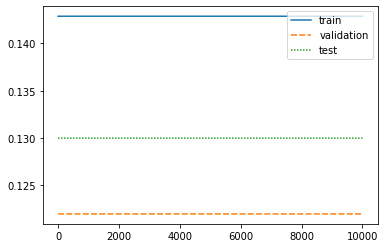

In [5]:
df_acc = pd.DataFrame({
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

sns.lineplot(data=df_acc)
plt.show()

In [6]:
spio.savemat('../variables/Cora/GNN.mat',{
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

In [7]:
print('Train Accuracy: {:.4f}'.format(accuracy(model, data, 'train')))
print('Validation Accuracy: {:.4f}'.format(accuracy(model, data, 'val')))
print('Test Accuracy: {:.4f}'.format(accuracy(model, data, 'test')))

Train Accuracy: 0.1429
Validation Accuracy: 0.1220
Test Accuracy: 0.1300


In [8]:
print('Test AUC: {:.4f}'.format(areaundercurve(model,data,'test')))

Test AUC: 0.5000


In [9]:
test_acc_all = np.array([0.7840, 0.7850, 0.7770, 0.7620, 0.7520])
test_auc_all = np.array([0.8839, 0.8846, 0.8829, 0.8727, 0.8799])

print(np.mean(test_acc_all))
print(np.mean(test_auc_all))

print(np.std(test_acc_all))
print(np.std(test_auc_all))

0.772
0.8808
0.012946041866145818
0.004356145084819836
